#  Машинный перевод с использованием рекуррентных нейронных сетей

__Автор задач: Блохин Н.В. (NVBlokhin@fa.ru)__

Материалы:
* Deep Learning with PyTorch (2020) Авторы: Eli Stevens, Luca Antiga, Thomas Viehmann
* https://pytorch.org/tutorials/intermediate/seq2seq_translation_tutorial.html#the-seq2seq-model
* https://www.adeveloperdiary.com/data-science/deep-learning/nlp/machine-translation-recurrent-neural-network-pytorch/

## Задачи для совместного разбора

1\. Рассмотрите пример архитектуры Encoder-Decoder с использованием RNN. Обсудите концепцию teacher forcing.

In [ ]:
import torch as th
import torch.nn as nn

In [ ]:
n_ru_tokens = 100
n_eng_tokens = 50
batch_size = 16
ru_seq_len = 20
en_seq_len = 25

ru = th.randint(0, n_ru_tokens, size=(batch_size, ru_seq_len))
en = th.randint(0, n_ru_tokens, size=(batch_size, en_seq_len))

In [ ]:
emb_dim = 32
hidden_dim = 100
encoder = nn.Sequential(
    nn.Embedding(n_ru_tokens, emb_dim, padding_idx=0),
    nn.GRU(emb_dim, hidden_dim, batch_first=True)
)
encoding = encoder(ru)[1] #  GRU возвращает (o, h), берем только скрытый слой
encoding.shape

torch.Size([1, 16, 100])

In [ ]:
EN_SOS = 1
class Decoder(nn.Module):
  def __init__(self, n_tokens, embedding_dim, hidden_dim, seq_len):
    super().__init__()
    self.embedding = nn.Embedding(n_tokens, embedding_dim, padding_idx=0)
    self.gru = nn.GRUCell(embedding_dim, hidden_dim)
    self.fc = nn.Linear(hidden_dim, n_tokens)
    self.seq_len = seq_len

  def forward(self, encoding, labels):
    batch_size = encoding.size(1)
    decoder_input = th.full(size=(batch_size, ), fill_value=EN_SOS) # b
    decoder_h = encoding[0]

    decoder_outputs = []

    for i in range(self.seq_len):
      emb = self.embedding(decoder_input) # b x e
      # ...
      decoder_h = self.gru(emb, decoder_h)
      out = self.fc(decoder_h) # b x n_tokens
      decoder_outputs.append(out)

      if labels:
        decoder_input = labels[:, i]
      else:
        decoder_input = out.argmax(dim=-1).detach() # b


    decoder_outputs = th.stack(decoder_outputs, dim=1)
    return decoder_outputs


In [ ]:
encoding.shape

torch.Size([1, 16, 100])

In [ ]:
decoder = Decoder(n_eng_tokens, embedding_dim=32, hidden_dim=100, seq_len=en_seq_len)
decoder(encoding).shape # b * en_seq_len * n_eng_tokens

torch.Size([16, 25, 50])

## Задачи для самостоятельного решения

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


<p class="task" id="1"></p>

1\. Считайте файлы `RuBQ_2.0_train.json` (обучающее множество) и `RuBQ_2.0_test.json` (тестовое множество). Для каждого файла создайте по списка: список предложений на русском языке и список предложений на английском языке. Выведите на экран количество примеров в обучающей и тестовой выборке.

Создайте два Vocab на основе загруженных данных: `ru_vocab` для слов на русском языке и `en_vocab` для слов на английском языке (словари создаются на основе обучающего множества). Добавьте в словари специальные токены `<PAD>`, `<UNK>`, `<SOS>`, `<EOS>`.

- [ ] Проверено на семинаре

In [ ]:
import pandas as pd
import torch
import torch.nn as nn

In [ ]:
df_train = pd.read_json('/content/drive/MyDrive/NLP/11/RuBQ_2.0_train.json')

In [ ]:
df_train.iloc[5]

,5
uid,6
question_text,Какой стране принадлежит остров Таити?
query,SELECT ?answer \nWHERE {\n wd:Q42000 wdt:P17 ...
answer_text,Франции
question_uris,[http://www.wikidata.org/entity/Q42000]
question_props,[wdt:P17]
answers,"[{'type': 'uri', 'label': 'Франция', 'value': ..."
paragraphs_uids,"{'with_answer': [35756, 35757, 35758, 35759], ..."
tags,[1-hop]
RuBQ_version,1


In [ ]:
df_train.iloc[5]['answers']

[{'type': 'uri',
  'label': 'Франция',
  'value': 'http://www.wikidata.org/entity/Q142',
  'wd_names': {'ru': ['ФР', 'France', 'Французская Республика', 'Франция'],
   'en': ['FR',
    'La France',
    'FRA',
    'France',
    'French Republic',
    'Republic of France',
    'fr',
    'République française']},
  'wp_names': ['Франции']}]

In [ ]:
df_train.iloc[5]['paragraphs_uids']

{'with_answer': [35756, 35757, 35758, 35759],
 'all_related': [35756,
  35757,
  35758,
  35759,
  35760,
  35761,
  35762,
  35763,
  35764,
  35765,
  35766,
  35767,
  35768,
  35769,
  35770,
  35781,
  35782,
  35783,
  35784,
  35785,
  35786,
  35787,
  35788,
  35789,
  35790]}

нужные столбцы:

- answers
- answer_text
- question_text (ru version)
- question_eng  (eng version)

остальные пока не предполагают в себе нужды

In [ ]:
df_train = df_train[['answers', 'answer_text', 'question_text', 'question_eng']]

In [ ]:
df_train

,answers,answer_text,question_text,question_eng
0,"[{'type': 'uri', 'label': 'землетрясение', 'va...",Землетрясение,Что может вызвать цунами?,What can cause a tsunami?
1,"[{'type': 'uri', 'label': 'Гарриет Бичер-Стоу'...",Г. Бичер-Стоу,Кто написал роман «Хижина дяди Тома»?,"Who wrote the novel ""uncle Tom's Cabin""?"
2,"[{'type': 'uri', 'label': 'Уильям Шекспир', 'v...",Шекспир,Кто автор пьесы «Ромео и Джульетта»?,"Who is the author of the play ""Romeo and Juliet""?"
3,"[{'type': 'uri', 'label': 'Бухарест', 'value':...",Бухарест,Как называется столица Румынии?,What is the name of the capital of Romania?
4,"[{'type': 'uri', 'label': 'гитара', 'value': '...",Гитара,На каком инструменте играл Джимми Хендрикс?,What instrument did Jimi Hendrix play?
...,...,...,...,...
2325,[],162,Какой высоты Ульмский собор в Германии?,How high is Ulm Cathedral in Germany?
2326,[],Швейцария,В какой стране зародился дадаизм?,In which country was the birthplace of the Dad...
2327,[],1974,В каком году сняли с производства Jaguar E-type?,In what year was the Jaguar E-type discontinued?
2328,[],1926,С какого года закончили выпускать Rolls-Royce ...,Since when has finished to produce the Rolls-R...


In [ ]:
df_train.iloc[2325]['answers'], bool(df_train.iloc[2325]['answers'])

([], False)

----------
**тут немного вопросов-размышлений**

нам надо создать датасет русских и английских предложений, а так же словари. Но тут вопрос, в словари же наверное надо добавить и слова из ответов? и если да, то стоит ли добавлять туда сами ответы (в примере выше с францией у нас в ответе измененная форма слова)

в добавок почему-то в русском варианте ответов у нас лежат английские слова, хотя так не везде

нужно их фильтровать получается

---------

upd. почитав задания дальше, я так понял, что ответы нам в целом ни к чему и тут можно использовать чисто взаимодействие вопросов

In [ ]:
df_train = df_train[['question_text', 'question_eng']]

In [ ]:
df_train

,question_text,question_eng
0,Что может вызвать цунами?,What can cause a tsunami?
1,Кто написал роман «Хижина дяди Тома»?,"Who wrote the novel ""uncle Tom's Cabin""?"
2,Кто автор пьесы «Ромео и Джульетта»?,"Who is the author of the play ""Romeo and Juliet""?"
3,Как называется столица Румынии?,What is the name of the capital of Romania?
4,На каком инструменте играл Джимми Хендрикс?,What instrument did Jimi Hendrix play?
...,...,...
2325,Какой высоты Ульмский собор в Германии?,How high is Ulm Cathedral in Germany?
2326,В какой стране зародился дадаизм?,In which country was the birthplace of the Dad...
2327,В каком году сняли с производства Jaguar E-type?,In what year was the Jaguar E-type discontinued?
2328,С какого года закончили выпускать Rolls-Royce ...,Since when has finished to produce the Rolls-R...


In [ ]:
from nltk import word_tokenize
import nltk
nltk.download('punkt_tab')

[nltk_data] Downloading package punkt_tab to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt_tab.zip.


True

In [ ]:
word_tokenize(df_train.iloc[2]['question_text'])

['Кто', 'автор', 'пьесы', '«', 'Ромео', 'и', 'Джульетта', '»', '?']

In [ ]:
word_tokenize(df_train.iloc[101]['question_text'])

['В',
 'какой',
 'земле',
 'Германии',
 'находится',
 'старинный',
 'город',
 'Веймар',
 ',',
 'где',
 'расположены',
 'музеи',
 'И.',
 'В.',
 'Гете',
 ',',
 'И.',
 'Ф.',
 'Шиллера',
 'и',
 'Ф.',
 'Листа',
 '?']

In [ ]:
word_tokenize(df_train.iloc[101]['question_eng'])

['In',
 'what',
 'land',
 'of',
 'Germany',
 'is',
 'the',
 'ancient',
 'city',
 'of',
 'Weimar',
 ',',
 'where',
 'the',
 'museums',
 'of',
 'Goethe',
 ',',
 'Schiller',
 'And',
 'Liszt',
 'are',
 'located',
 '?']

------
разница языков в том, что в русском иногда добавляются инициалы некоторых людей, а в английском языке нет

стоит ли их чистить?

вопрос в том как добавлять это в словарь, это уникальные токены и без точки они имеют другой смысл, но для перевода они не несут никакого смысла
даже если нужен будет перевод англ -> рус, то модель или не добавит инициалы или будет добавлять где-то лишние/неправильные --> нужно чистить (это лишний шум)

------


In [ ]:
x = 'Sfe fefe Sfef'
x = x[0].lower() + x[1:]
x

'sfe fefe Sfef'

In [ ]:
import re

In [ ]:
x = df_train.iloc[101]['question_text']
print(x)
x = re.sub(r'\b[А-ЯЁ]\.\s?', '', x) # убираю ток заглавную букву с точкой - инициалы
print(x)
print(df_train.iloc[101]['question_eng'])

# тут недочет о котором сразу не подумал, возможно будут инициалы в обоих языках, тогда возможно стоит удалить их везде

В какой земле Германии находится старинный город Веймар, где расположены музеи И. В. Гете, И. Ф. Шиллера и Ф. Листа?
В какой земле Германии находится старинный город Веймар, где расположены музеи Гете, Шиллера и Листа?
In what land of Germany is the ancient city of Weimar, where the museums of Goethe, Schiller And Liszt are located?


In [ ]:
def preprocessing(x):
    x = x[0].lower() + x[1:]
    x = re.sub(r'\b[А-ЯЁA-Z]\.\s?', '', x)
    return word_tokenize(x)

In [ ]:
train_ru_sents, train_eng_sents = [], []

In [ ]:
for idx, sents in df_train.iterrows():
    ru, eng = sents['question_text'], sents['question_eng']
    train_ru_sents.append(preprocessing(ru))
    train_eng_sents.append(preprocessing(eng))

In [ ]:
x = [[1, 2], [2, 2]]
x = [g for i in x for g in i]
x

[1, 2, 2, 2]

In [ ]:
ru_vocab = [g for i in train_ru_sents for g in i]
eng_vocab = [g for i in train_eng_sents for g in i]

ru_vocab = list(set(ru_vocab))
eng_vocab = list(set(eng_vocab))

In [ ]:
len(ru_vocab), len(eng_vocab)

(6097, 4433)

In [ ]:
x = '<PAD>, <UNK>, <SOS>, <EOS>'.split(', ')
x

['<PAD>', '<UNK>', '<SOS>', '<EOS>']

In [ ]:
ru_vocab = x + ru_vocab
eng_vocab = x + eng_vocab

In [ ]:
ru_vocab = {word: idx for idx, word in enumerate(ru_vocab)}
eng_vocab = {word: idx for idx, word in enumerate(eng_vocab)}

In [ ]:
ru_vocab

{'<PAD>': 0,
 '<UNK>': 1,
 '<SOS>': 2,
 '<EOS>': 3,
 'уже': 4,
 'отмечают': 5,
 'позже': 6,
 'Лиза': 7,
 'который': 8,
 'президентам': 9,
 'комсомол': 10,
 'гепатит': 11,
 'войне': 12,
 'Поттер': 13,
 'чемпионата': 14,
 'идентичный': 15,
 'осуществил': 16,
 'Евграфа': 17,
 'Папа': 18,
 'единица': 19,
 'докучаевская': 20,
 'Билли': 21,
 'круиза': 22,
 'Хуан': 23,
 'имя': 24,
 'Дэвида': 25,
 'олимпийским': 26,
 'Сиримаво': 27,
 'слова': 28,
 'Планета': 29,
 'Боснии': 30,
 'составляет': 31,
 'видам': 32,
 'последним': 33,
 'дети': 34,
 'часть': 35,
 'Кириленко': 36,
 'двоеборья': 37,
 'Фред': 38,
 'количество': 39,
 'Международный': 40,
 'силу': 41,
 'понимаю': 42,
 'пришлось': 43,
 'Макао': 44,
 'езде': 45,
 'должен': 46,
 'легким': 47,
 'июля': 48,
 'здоровыми': 49,
 'Васильевич': 50,
 'Айлиш': 51,
 'Охеды': 52,
 'Австрии': 53,
 'Джосера': 54,
 'Дикси': 55,
 'министры': 56,
 'гонок': 57,
 'университета': 58,
 'оно': 59,
 'III-II': 60,
 'Кирилл': 61,
 'побережье': 62,
 'футбольному': 63,

In [ ]:
df_test = pd.read_json('/content/drive/MyDrive/NLP/11/RuBQ_2.0_test.json')
df_test.head()

,uid,question_text,query,answer_text,question_uris,question_props,answers,paragraphs_uids,tags,RuBQ_version,question_eng
0,4,Какой стране принадлежит знаменитый остров Пасхи?,SELECT ?answer \nWHERE {\n wd:Q14452 wdt:P17 ...,Чили,[http://www.wikidata.org/entity/Q14452],[wdt:P17],"[{'type': 'uri', 'label': 'Чили', 'value': 'ht...","{'with_answer': [10785, 10782, 10783], 'all_re...",[1-hop],1,Which country does the famous Easter island be...
1,7,С какой музыкальной группой неразрывно связано...,SELECT ?answer \nWHERE {\n wd:Q128121 wdt:P36...,'Роллинг Стоунз',[http://www.wikidata.org/entity/Q128121],[wdt:P361],"[{'type': 'uri', 'label': 'The Rolling Stones'...","{'with_answer': [53040, 53037, 53038, 53039], ...",[1-hop],1,Which music group is Mick Jagger's name inextr...
2,14,Где находится Летний сад?,SELECT ?answer \nWHERE {\n wd:Q1229234 wdt:P1...,Санкт-Петербург,[http://www.wikidata.org/entity/Q1229234],[wdt:P131],"[{'type': 'uri', 'label': 'Санкт-Петербург', '...","{'with_answer': [25080, 25067], 'all_related':...",[1-hop],1,Where is the Summer garden?
3,22,Какой город является столицей Туркмении?,SELECT ?answer \nWHERE {\n wd:Q874 wdt:P36 ?a...,Ашхабад,[http://www.wikidata.org/entity/Q874],[wdt:P36],"[{'type': 'uri', 'label': 'Ашхабад', 'value': ...","{'with_answer': [14910], 'all_related': [11522...",[1-hop],1,Which city is the capital of Turkmenistan?
4,25,В каком городе издавалась с 1857 г. А. Герцено...,SELECT ?answer \nWHERE {\n wd:Q2533402 wdt:P1...,Лондон,[http://www.wikidata.org/entity/Q2533402],[wdt:P159],"[{'type': 'uri', 'label': 'Женева', 'value': '...","{'with_answer': [], 'all_related': [53072, 530...",[1-hop],1,In which city was the first Russian revolution...


In [ ]:
df_test = df_test[['question_text', 'question_eng']]

In [ ]:
test_ru_sents, test_eng_sents = [], []

In [ ]:
for idx, sents in df_test.iterrows():
    ru, eng = sents['question_text'], sents['question_eng']
    test_ru_sents.append(preprocessing(ru))
    test_eng_sents.append(preprocessing(eng))

In [ ]:
len(train_ru_sents), len(train_eng_sents)

(2330, 2330)

In [ ]:
len(test_ru_sents), len(test_eng_sents)

(580, 580)

контрольная точка

- [x] ru_sents
- [x] eng_sents\
Выведите на экран количество примеров в обучающей и тестовой выборке.
- [x] аналогично для test<br><br>
- [x] ru_vocab
- [x] eng_vocab

`<PAD>`, `<UNK>`, `<SOS>`, `<EOS>`


<p class="task" id="2"></p>

2\. Создайте класс `RuEnDataset`. Реализуйте `__getitem__` таким образом, чтобы он возвращал кортеж `(x, y)`, где x - это набор индексов токенов для предложений на русском языке, а `y` - набор индексов токенов для предложений на английском языке. Используя преобразования, сделайте длины наборов индексов одинаковой фиксированной длины, добавьте в начало каждого набора индекс `<SOS>`, а в конец - индекс токена `<EOS>`. Создайте датасет для обучающей и тестовой выборки.

- [ ] Проверено на семинаре

In [ ]:
max_len1 = max(max(map(len, train_ru_sents)), max(map(len, train_eng_sents)))
max_len2 = max(max(map(len, test_ru_sents)), max(map(len, test_eng_sents)))

max_len = max(max_len1, max_len2) + 2 # 2 - sos+eos
max_len

35

In [ ]:
x

['<PAD>', '<UNK>', '<SOS>', '<EOS>']

In [ ]:
for i in x:
    print(i, ru_vocab[i])

<PAD> 0
<UNK> 1
<SOS> 2
<EOS> 3


In [ ]:
[2] +[2131, 123]

[2, 2131, 123]

In [ ]:
from torch.utils.data import Dataset


class RuEnDataset(Dataset):
    def __init__(self, ru_vocab, eng_vocab, X, y, max_len):
        self.ru_vocab = ru_vocab
        self.eng_vocab = eng_vocab

        self.X = []
        for sent in X:
            tokens = [ru_vocab.get(i, 1) for i in sent]   # 1 = unk
            tokens = [2] + tokens + [3]
            if len(tokens) < max_len:
                tokens += [0] * (max_len - len(tokens))  # 0 = pad
            self.X.append(tokens)



        self.y = []
        for sent in y:
            tokens = [eng_vocab.get(i, 1) for i in sent]   # 1 = unk
            tokens = [2] + tokens + [3]
            if len(tokens) < max_len:
                tokens += [0] * (max_len - len(tokens))  # 0 = pad
            self.y.append(tokens)


    def __len__(self):
        return len(self.X)


    def __getitem__(self, idx):
        return torch.tensor(self.X[idx], dtype=torch.long), torch.tensor(self.y[idx], dtype=torch.long)

In [ ]:
train_dataset = RuEnDataset(ru_vocab=ru_vocab, eng_vocab=eng_vocab, X=train_ru_sents, y=train_eng_sents, max_len=max_len)
test_dataset = RuEnDataset(ru_vocab=ru_vocab, eng_vocab=eng_vocab, X=test_ru_sents, y=test_eng_sents, max_len=max_len)

In [ ]:
x, y = train_dataset[:5]
print(x.shape, y.shape)

torch.Size([5, 35]) torch.Size([5, 35])


контрольная точка

- [x] sos eos
- [x] getitem
- [x] RuEnDataset <br><br>
- [x] train test

<p class="task" id="4"></p>

3\. Опишите модель `Encoder`, которая возвращает скрытое состояние рекуррентного слоя в соотстветствии со следующей схемой. Пропустите через эту модель первые 16 предложений на русском языке и выведите размер полученного результата на экран. Результатом должен являться тензор размера `1 x batch_size x hidden_dim` (если используется один однонаправленный рекуррентный слой и `batch_first=True`).

* количество эмбеддингов равно количеству слов на русском языке;
* размерность эмбеддингов выберите самостоятельно;
* при создании слоя эмбеддингов укажите `padding_idx`;
* размер скрытого состояния рекуррентного слоя выберите самостоятельно.

![encoder](https://adeveloperdiary.com/assets/img/Machine-Translation-using-Recurrent-Neural-Network-and-PyTorch-adeveloperdiary.com-1.webp)

- [ ] Проверено на семинаре

In [ ]:
from torch.utils.data import DataLoader
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [ ]:
train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=64)

In [ ]:
class Encoder(nn.Module):
    def __init__(self, vocab_size, embedding_dim, hidden_size):
        super().__init__()
        self.embedding = nn.Embedding(vocab_size, embedding_dim, padding_idx=0)
        self.rnn = nn.GRU(input_size=embedding_dim, hidden_size=hidden_size, batch_first=True)

    def forward(self, x):
        x = self.embedding(x)
        o, h = self.rnn(x)
        return h

In [ ]:
model = Encoder(len(ru_vocab), 300, 128)
model = model.to(device)

In [ ]:
for x_batch, y_batch in train_loader:
    h = model.forward(x_batch.to(device))
    print(x_batch.shape) # batch x max_len
    print(y_batch.shape)
    print(h.shape)       # 1 x batch x hidden_size
    break

torch.Size([64, 35])
torch.Size([64, 35])
torch.Size([1, 64, 128])


<p class="task" id="5"></p>

4\. Опишите модель `Decoder`, которая возвращает прогноз (набор индексов слов на английском языке). Пропустите через эту модель тензор скрытых состояний кодировщика, полученный в предыдущей задачи, и выведите размер полученного результата на экран. Результатом должен являться тензор размера `batch_size x seq_len x n_en_words` (если используется один однонаправленный рекуррентный слой и `batch_first=True`).

* количество эмбеддингов равно количеству слов на английском языке;
* размер выходного слоя равен количеству слов на английском языке;
* размерность эмбеддингов выберите самостоятельно;
* при создании слоя эмбеддингов укажите `padding_idx`;
* размер скрытого состояния рекуррентного слоя выберите самостоятельно.

![decoder](https://adeveloperdiary.com/assets/img/Machine-Translation-using-Recurrent-Neural-Network-and-PyTorch-adeveloperdiary.com-2.webp)

- [ ] Проверено на семинаре

In [ ]:
EN_SOS = eng_vocab['<SOS>']
EN_SOS

2

In [ ]:
class Decoder(nn.Module):
  def __init__(self, n_tokens, embedding_dim, hidden_dim, seq_len):
    super().__init__()
    self.embedding = nn.Embedding(n_tokens, embedding_dim, padding_idx=0)
    self.gru = nn.GRUCell(embedding_dim, hidden_dim)
    self.fc = nn.Linear(hidden_dim, n_tokens)
    self.seq_len = seq_len

  def forward(self, encoding, labels):
    batch_size = encoding.size(1)
    decoder_input = torch.full(size=(batch_size, ), fill_value=EN_SOS, device=encoding.device) # b
    decoder_h = encoding[0]

    decoder_outputs = []

    for i in range(self.seq_len-1):
      emb = self.embedding(decoder_input) # b x e

      decoder_h = self.gru(emb, decoder_h)
      out = self.fc(decoder_h) # b x n_tokens
      decoder_outputs.append(out)

      if labels is not None:
        decoder_input = labels[:, i]
      else:
        decoder_input = out.argmax(dim=-1).detach() # b


    decoder_outputs = torch.stack(decoder_outputs, dim=1)
    return decoder_outputs


--------
**примечания**

так как мы изначально создаем
```
    decoder_input = torch.full(size=(batch_size, ), fill_value=EN_SOS)
```
то у нас изначально уже подается первый токен \<sos> <br>
тогда получается что мы предсказываем последующие 34 символа

ведь если мы будем подавать все labels, тогда после нашего первого decoder_input = \<sos> мы должны предсказать его снова же

получается что лучше предсказывать последующие 34 токена и подавать внутрь labels[:, 1:]

In [ ]:
decoder = Decoder(len(eng_vocab), 300, 128, max_len)
decoder = decoder.to(device)

In [ ]:
h.device

device(type='cuda', index=0)

In [ ]:
out = decoder.forward(h, labels=None)
out.shape # batch x seq_len-1 x eng_vocab

torch.Size([64, 34, 4437])

In [ ]:
out = out.view(-1, len(eng_vocab))
out.shape

torch.Size([2176, 4437])

<p class="task" id="5"></p>

5\. Объедините модели `Encoder` и `Decoder` в одну модель `EncoderDecoder`. Настройте модель, решив задачу классификации. Игнорируйте токен `<PAD>` при расчете ошибки. Во время обучения выводите на экран значения функции потерь для эпохи (на обучающем множестве), значение accuracy по токенам (на обучающем множестве) и пример перевода, сгенерированного моделью. После завершения обучения посчитайте BLEU для тестового множества.

- [ ] Проверено на семинаре

In [ ]:
class EncoderDecoder(nn.Module):
    def __init__(self, encoder, decoder):
        super().__init__()
        self.encoder = encoder
        self.decoder = decoder


    def forward(self, x, labels=None):
        encoding = self.encoder(x)
        decoding = self.decoder(encoding, labels)
        return decoding

In [ ]:
device

device(type='cuda')

In [ ]:
encoder = Encoder(len(ru_vocab), 300, 128)
encoder = encoder.to(device)

decoder = Decoder(len(eng_vocab), 300, 128, max_len)
decoder = decoder.to(device)

model = EncoderDecoder(encoder, decoder)
model = model.to(device)

In [ ]:
optim = torch.optim.AdamW(model.parameters(), lr=0.003)
criterion = nn.CrossEntropyLoss(ignore_index=0)
epochs = 20

In [ ]:
def accuracy_score(preds, y_true):
    preds = preds.argmax(dim=-1)
    mask = y_true != 0 # считаем правильными только предсказанные нами слова без падингов
    correct = (preds == y_true) & mask
    accuracy = correct.sum().item() / mask.sum().item()
    return accuracy

In [ ]:
from tqdm import tqdm

In [ ]:
ru_inverse = dict([(idx, v) for v, idx in ru_vocab.items()])
eng_inverse = dict([(idx, v) for v, idx in eng_vocab.items()])

In [ ]:
for epoch in range(epochs):
    model.train()
    total_loss = 0
    total_acc = 0
    all_preds = []
    all_labels = []


    loop = tqdm(train_loader, desc=f'Epoch: {epoch+1}/{epochs}', leave=False)
    for x_batch, y_batch in loop:
        x_batch, y_batch = x_batch.to(device), y_batch.to(device)

        optim.zero_grad()

        y_true = y_batch[:, 1:].to(device)
        logits = model(x_batch.to(device), y_true.to(device))

        loss = criterion(logits.reshape(-1, len(eng_vocab)), y_batch[:, 1:].reshape(-1))
        acc = accuracy_score(logits, y_true)

        loss.backward()
        optim.step()

        total_loss += loss.item()
        total_acc += acc


        loop.set_description(f"Epoch {epoch+1}/{epochs} | loss: {loss.item():.4f} | acc: {acc:.4f}")

    avg_loss = total_loss / len(train_loader)
    avg_acc = total_acc / len(train_loader)
    tqdm.write(f"Epoch {epoch+1} — avg loss: {avg_loss:.4f}, avg acc: {avg_acc:.4f}")


    # предсказание после каждой эпохи
    model.eval()
    with torch.no_grad():
        for x, y in test_loader:
            x, y = x.to(device), y.to(device)
            encoding = model.encoder(x)
            logits = model.decoder(encoding, labels=None)
            pred = logits.argmax(dim=-1)[0]
            pred_tokens = [eng_inverse[i] for i in pred.tolist()]

            y_true = y[0]
            y_true = [eng_inverse[i] for i in y_true.tolist()]

            tqdm.write("True: " + " ".join(y_true))
            tqdm.write("Example: " + " ".join(pred_tokens))
            break

Epoch 1 — avg loss: 5.5857, avg acc: 0.3046
True: <SOS> which country does the famous <UNK> island belong to ? <EOS> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD>
Example: what is the of the of the of the of the of the of the of the of the of the of the of the of the of the of the of the of


Epoch 2 — avg loss: 4.1977, avg acc: 0.3720
True: <SOS> which country does the famous <UNK> island belong to ? <EOS> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD>
Example: what is the name of the name of the name of the first of the first of the first of the first of the first of the first of the first of the first


Epoch 3 — avg loss: 3.6888, avg acc: 0.4171
True: <SOS> which country does the famous <UNK> island belong to ? <EOS> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD>
Example: what is the name of the capital of the state of the capital of the Russian ? <EOS> of the Russian ? <EOS> of the Russian ? <EOS> of the Russian ? <EOS> of


Epoch 4 — avg loss: 3.2207, avg acc: 0.4589
True: <SOS> which country does the famous <UNK> island belong to ? <EOS> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD>
Example: what is the name of the city of the capital of the state of the state of the city of the state of the state of the city of the state of the state


Epoch 5 — avg loss: 2.8023, avg acc: 0.5007
True: <SOS> which country does the famous <UNK> island belong to ? <EOS> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD>
Example: what is the name of the city of the capital of the United States ? <EOS> of the film `` the '' ? <EOS> of the `` '' ? <EOS> of the `` ''


Epoch 6 — avg loss: 2.4397, avg acc: 0.5410
True: <SOS> which country does the famous <UNK> island belong to ? <EOS> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD>
Example: which city is the capital of the Republic of the USSR ? <EOS> ? <EOS> ? <EOS> ? <EOS> ? <EOS> ? <EOS> ? <EOS> ? <EOS> ? <EOS> ? <EOS> ? <EOS> ?


Epoch 7 — avg loss: 2.1229, avg acc: 0.5885
True: <SOS> which country does the famous <UNK> island belong to ? <EOS> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD>
Example: which country 's capital is the city of the Republic of the Republic of the USSR ? <EOS> of the `` the '' ? <EOS> `` the '' ? <EOS> `` the '' ?


Epoch 8 — avg loss: 1.8356, avg acc: 0.6396
True: <SOS> which country does the famous <UNK> island belong to ? <EOS> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD>
Example: which country 's capital is the city of Naberezhnye Chelny ? <EOS> of the `` the '' ? <EOS> `` the '' ? <EOS> `` the '' ? <EOS> `` the '' ? <EOS>


Epoch 9 — avg loss: 1.6040, avg acc: 0.6803
True: <SOS> which country does the famous <UNK> island belong to ? <EOS> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD>
Example: which city is the capital of the Republic of Buryatia ? <EOS> and the `` yellow signal '' ? <EOS> <EOS> ? <EOS> <EOS> ? <EOS> <EOS> ? <EOS> <EOS> ? <EOS> <EOS> ?


Epoch 10 — avg loss: 1.4086, avg acc: 0.7194
True: <SOS> which country does the famous <UNK> island belong to ? <EOS> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD>
Example: which city is the capital of the Republic of Buryatia ? <EOS> ? <EOS> ? <EOS> ? <EOS> ? <EOS> ? <EOS> ? <EOS> ? <EOS> ? <EOS> ? <EOS> ? <EOS> ? <EOS>


Epoch 11 — avg loss: 1.2600, avg acc: 0.7482
True: <SOS> which country does the famous <UNK> island belong to ? <EOS> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD>
Example: which city is the capital of the Republic of Dagestan ? <EOS> `` the Tale of Siyavush '' ? <EOS> `` the Tale of Siyavush '' ? <EOS> `` the Tale of Siyavush ''


Epoch 12 — avg loss: 1.1421, avg acc: 0.7688
True: <SOS> which country does the famous <UNK> island belong to ? <EOS> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD>
Example: which city is the capital of the Republic of Dagestan ? <EOS> `` the Black man '' ? <EOS> `` the Tale of Siyavush '' ? <EOS> `` the Field of Miracles ? <EOS>


Epoch 13 — avg loss: 1.0412, avg acc: 0.7886
True: <SOS> which country does the famous <UNK> island belong to ? <EOS> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD>
Example: which country is the birthplace of the saxophone ? <EOS> <EOS> ? <EOS> <EOS> ? <EOS> <EOS> ? <EOS> <EOS> ? <EOS> <EOS> ? <EOS> <EOS> ? <EOS> <EOS> ? <EOS> <EOS> ? <EOS>


Epoch 14 — avg loss: 0.9616, avg acc: 0.8053
True: <SOS> which country does the famous <UNK> island belong to ? <EOS> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD>
Example: which city is the capital of the Republic of Buryatia ? <EOS> and the `` commutativity '' ? <EOS> `` the Tale of Siyavush '' ? <EOS> `` the Tale of Siyavush '' ?


Epoch 15 — avg loss: 0.8899, avg acc: 0.8199
True: <SOS> which country does the famous <UNK> island belong to ? <EOS> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD>
Example: which country 's capital is Baku ? <EOS> <EOS> ? <EOS> <EOS> ? <EOS> <EOS> ? <EOS> <EOS> ? <EOS> <EOS> ? <EOS> <EOS> ? <EOS> <EOS> ? <EOS> <EOS> ? <EOS> <EOS> ?


Epoch 16 — avg loss: 0.8321, avg acc: 0.8314
True: <SOS> which country does the famous <UNK> island belong to ? <EOS> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD>
Example: which of the world is the highest point in Poland ? <EOS> `` the Tale of Siyavush '' ? <EOS> `` the Tale of Siyavush '' ? <EOS> `` the Tale of Siyavush ''


Epoch 17 — avg loss: 0.7818, avg acc: 0.8381
True: <SOS> which country does the famous <UNK> island belong to ? <EOS> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD>
Example: which country 's capital is Baku ? <EOS> <EOS> ? <EOS> <EOS> ? <EOS> <EOS> ? <EOS> <EOS> ? <EOS> <EOS> ? <EOS> <EOS> ? <EOS> <EOS> ? <EOS> <EOS> ? <EOS> <EOS> ?


Epoch 18 — avg loss: 0.7375, avg acc: 0.8454
True: <SOS> which country does the famous <UNK> island belong to ? <EOS> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD>
Example: in which country is the birthplace of the saxophone ? <EOS> `` the Tale of Siyavush '' ? <EOS> `` the Tale of Siyavush '' ? <EOS> `` the Tale of Siyavush '' ?


Epoch 19 — avg loss: 0.6968, avg acc: 0.8518
True: <SOS> which country does the famous <UNK> island belong to ? <EOS> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD>
Example: in which country is the city of Coventry located ? <EOS> `` the '' ? <EOS> `` the Tale of Siyavush '' ? <EOS> `` the Tale of Siyavush '' ? <EOS> `` the


Epoch 20 — avg loss: 0.6633, avg acc: 0.8560
True: <SOS> which country does the famous <UNK> island belong to ? <EOS> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD>
Example: in which country did the risotto dish come up ? <EOS> `` the adventures of Pinocchio '' ? <EOS> `` the Tale of Rustam '' , `` Rustam and Suhrab '' , `` the


In [ ]:
from nltk.translate.bleu_score import corpus_bleu

In [ ]:
spec_idx = [0, 1, 2, 3]
spec_idx

[0, 1, 2, 3]

In [ ]:
model.eval()
preds = []
true = []

with torch.no_grad():
    for x, y in tqdm(test_loader, desc="BLEU Evaluation"):
        x, y = x.to(device), y.to(device)

        encoding = model.encoder(x)
        logits = model.decoder(encoding, labels=None)

        pred = logits.argmax(dim=-1)  # b x seq

        for i in range(x.size(0)):
            pred_indices = pred[i].tolist()
            true_indices = y[i].tolist()


            pred_tokens = [eng_inverse[idx] for idx in pred_indices if idx not in spec_idx]
            true_tokens = [eng_inverse[idx] for idx in true_indices if idx not in spec_idx]

            preds.append(pred_tokens)
            true.append([true_tokens])

# Расчёт BLEU
bleu = corpus_bleu(true, preds)
print(f"BLEU: {bleu:.4f}")


BLEU Evaluation: 100%|██████████| 10/10 [00:00<00:00, 78.10it/s]


BLEU: 0.0455


<p class="task" id="6"></p>

6*\. Создайте и обучите модель машинного перевода, используя архитектуру Encoder-Decoder на основе RNN с использованием механизма аддитивного внимания. Во время обучения выводите на экран значения функции потерь для эпохи (на обучающем множестве), значение accuracy по токенам (на обучающем множестве) и пример перевода, сгенерированного моделью. После завершения обучения посчитайте BLEU для тестового множества.

Сгенерируйте перевод при помощи обученной модели и визуализируйте матрицу внимания, в которой отображено, на какие слова из исходного предложения модель обращала внимание при генерации очередного слова в переводе.

- [ ] Проверено на семинаре

In [ ]:
class Encoder(nn.Module):
    def __init__(self, vocab_size, embedding_dim, hidden_size):
        super().__init__()
        self.embedding = nn.Embedding(vocab_size, embedding_dim, padding_idx=0)
        self.rnn = nn.GRU(input_size=embedding_dim, hidden_size=hidden_size, batch_first=True)

    def forward(self, x):
        x = self.embedding(x)
        o, h = self.rnn(x)
        return o,h

In [ ]:
encoder = Encoder(len(ru_vocab), 300, 128)
encoder = encoder.to(device)

In [ ]:
for x_batch, y_batch in train_loader:
    o, h = encoder.forward(x_batch.to(device))
    print(x_batch.shape) # batch x max_len
    print(y_batch.shape)
    print(h.shape)       # 1 x batch x hidden_size
    print(o.shape) # b x seq x h
    break

torch.Size([64, 35])
torch.Size([64, 35])
torch.Size([1, 64, 128])
torch.Size([64, 35, 128])


In [ ]:
x = torch.rand([10, 20])
x = x.unsqueeze(1)
x.shape

torch.Size([10, 1, 20])

**механизм внимания**

1. прогнать o и h по W (linear)
2. привести к одной размерности
3. тангенс от их суммы
4. прогнать по v (linear)
5. распределение softmax (0, 1) = att_weights
6. bmm (перемножение по батчам) между att_weights и outputs (o)

bmm: X (b 1, seq) * Y (b, seq, h) = z (b, 1, h)

In [ ]:
seq_len = max_len
seq_len

35

In [ ]:
class Decoder(nn.Module):
  def __init__(self, n_tokens, embedding_dim, hidden_dim, att_dim, seq_len):
    super().__init__()
    self.embedding = nn.Embedding(n_tokens, embedding_dim, padding_idx=0)
    self.gru = nn.GRUCell(embedding_dim + hidden_dim, hidden_dim)
    self.fc = nn.Linear(hidden_dim, n_tokens)
    self.seq_len = seq_len

    self.W_h = nn.Linear(hidden_dim, att_dim)
    self.W_o = nn.Linear(hidden_dim, att_dim)
    self.v = nn.Linear(att_dim, 1)


  def forward(self, encoding, enc_o, labels=None):
    batch_size = encoding.size(1)
    decoder_input = torch.full(size=(batch_size, ), fill_value=EN_SOS, device=encoding.device) # b
    decoder_h = encoding[0]

    decoder_outputs = []
    att_weights = []

    for i in range(self.seq_len-1):
        # 1.
        W_h = self.W_h(encoding)
        W_o = self.W_o(enc_o)

        # 2.
        W_h = W_h.transpose(0, 1).repeat([1, seq_len, 1]) # b x seq x att

        # 3.
        tanh_sum = torch.tanh(W_h + W_o)

        # 4.
        res = self.v(tanh_sum).squeeze() # убираем размерность для софтмакса

        # 5.
        att_weight = torch.softmax(res, dim=1) # b x seq
        att_weights.append(att_weight)

        # 6.
        context = torch.bmm(att_weight.unsqueeze(1), enc_o) # b x 1 x h


        emb = self.embedding(decoder_input) # b x e

        rnn_input = torch.cat([emb, context.squeeze(1)], dim=1)

        decoder_h = self.gru(rnn_input, decoder_h)
        out = self.fc(decoder_h) # b x n_tokens
        decoder_outputs.append(out)

        if labels is not None:
            decoder_input = labels[:, i]
        else:
            decoder_input = out.argmax(dim=-1).detach() # b


    decoder_outputs = torch.stack(decoder_outputs, dim=1)
    att_weights = torch.stack(att_weights, dim=1)
    return decoder_outputs, att_weights


In [ ]:
class EncoderDecoder(nn.Module):
    def __init__(self, encoder, decoder):
        super().__init__()
        self.encoder = encoder
        self.decoder = decoder


    def forward(self, x, labels=None):
        o, encoding = self.encoder(x)
        decoding, att_weights = self.decoder(encoding, o, labels)
        return decoding, att_weights

In [ ]:
encoder = Encoder(len(ru_vocab), 300, 128)
encoder = encoder.to(device)

decoder = Decoder(len(eng_vocab), 300, 128, 128, max_len) #att=128
decoder = decoder.to(device)

model = EncoderDecoder(encoder, decoder)
model = model.to(device)

In [ ]:
optim = torch.optim.AdamW(model.parameters(), lr=0.002)
criterion = nn.CrossEntropyLoss(ignore_index=0)
epochs = 20

In [ ]:
def accuracy_score(preds, y_true):
    preds = preds.argmax(dim=-1)
    mask = y_true != 0 # считаем правильными только предсказанные нами слова без падингов
    correct = (preds == y_true) & mask
    accuracy = correct.sum().item() / mask.sum().item()
    return accuracy

In [ ]:
for epoch in range(epochs):
    model.train()
    total_loss = 0
    total_acc = 0
    all_preds = []
    all_labels = []


    loop = tqdm(train_loader, desc=f'Epoch: {epoch+1}/{epochs}', leave=False)
    for x_batch, y_batch in loop:
        x_batch, y_batch = x_batch.to(device), y_batch.to(device)

        optim.zero_grad()

        y_true = y_batch[:, 1:].to(device)
        logits, _ = model(x_batch, y_true)

        loss = criterion(logits.reshape(-1, len(eng_vocab)), y_batch[:, 1:].reshape(-1))
        acc = accuracy_score(logits, y_true)

        loss.backward()
        optim.step()

        total_loss += loss.item()
        total_acc += acc


        loop.set_description(f"Epoch {epoch+1}/{epochs} | loss: {loss.item():.4f} | acc: {acc:.4f}")

    avg_loss = total_loss / len(train_loader)
    avg_acc = total_acc / len(train_loader)
    tqdm.write(f"Epoch {epoch+1} — avg loss: {avg_loss:.4f}, avg acc: {avg_acc:.4f}")


    # предсказание после каждой эпохи
    model.eval()
    with torch.no_grad():
        for x, y in test_loader:
            x, y = x.to(device), y.to(device)
            o, encoding = model.encoder(x)
            logits, _ = model.decoder(encoding, o, labels=None)
            pred = logits.argmax(dim=-1)[0]
            pred_tokens = [eng_inverse[i] for i in pred.tolist()]

            y_true = y[0]
            y_true = [eng_inverse[i] for i in y_true.tolist()]

            tqdm.write("True: " + " ".join(y_true))
            tqdm.write("Example: " + " ".join(pred_tokens))
            break

Epoch 1 — avg loss: 5.6812, avg acc: 0.2653
True: <SOS> which country does the famous <UNK> island belong to ? <EOS> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD>
Example: what is the of the of the of the of the of the of the of the of the of the of the of the of the of the of the of the of


Epoch 2 — avg loss: 4.3533, avg acc: 0.3571
True: <SOS> which country does the famous <UNK> island belong to ? <EOS> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD>
Example: what is the name of the of the of the of the of the of the of the of the of the of the of the of the of the of the of the


Epoch 3 — avg loss: 3.9303, avg acc: 0.3886
True: <SOS> which country does the famous <UNK> island belong to ? <EOS> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD>
Example: what is the name of the famous of the first of the first ? <EOS> ? <EOS> ? <EOS> ? <EOS> ? <EOS> ? <EOS> ? <EOS> ? <EOS> ? <EOS> ? <EOS> ?


Epoch 4 — avg loss: 3.5357, avg acc: 0.4367
True: <SOS> which country does the famous <UNK> island belong to ? <EOS> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD>
Example: what is the name of the city of the Russian Federation ? <EOS> ? <EOS> ? <EOS> ? <EOS> ? <EOS> ? <EOS> ? <EOS> ? <EOS> ? <EOS> ? <EOS> ? <EOS> ?


Epoch 5 — avg loss: 3.1732, avg acc: 0.4732
True: <SOS> which country does the famous <UNK> island belong to ? <EOS> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD>
Example: what is the name of the world Cup ? <EOS> ? <EOS> ? <EOS> ? <EOS> ? <EOS> ? <EOS> ? <EOS> ? <EOS> ? <EOS> ? <EOS> ? <EOS> ? <EOS> ? <EOS>


Epoch 6 — avg loss: 2.8358, avg acc: 0.5102
True: <SOS> which country does the famous <UNK> island belong to ? <EOS> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD>
Example: what is the name of the Russian Federation established ? <EOS> ? <EOS> ? <EOS> ? <EOS> ? <EOS> ? <EOS> ? <EOS> ? <EOS> ? <EOS> ? <EOS> ? <EOS> ? <EOS> ?


Epoch 7 — avg loss: 2.5342, avg acc: 0.5461
True: <SOS> which country does the famous <UNK> island belong to ? <EOS> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD>
Example: what country is the capital of the Republic of the USSR ? <EOS> ? <EOS> ? <EOS> ? <EOS> ? <EOS> ? <EOS> ? <EOS> ? <EOS> ? <EOS> ? <EOS> ? <EOS> ?


Epoch 8 — avg loss: 2.2591, avg acc: 0.5775
True: <SOS> which country does the famous <UNK> island belong to ? <EOS> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD>
Example: in which country is the city of Naberezhnye Chelny ? <EOS> ? <EOS> ? <EOS> ? <EOS> ? <EOS> ? <EOS> ? <EOS> ? <EOS> ? <EOS> ? <EOS> ? <EOS> ? <EOS> ?


Epoch 9 — avg loss: 2.0004, avg acc: 0.6187
True: <SOS> which country does the famous <UNK> island belong to ? <EOS> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD>
Example: which country is the birthplace of the Republic of the USSR established ? <EOS> ? <EOS> ? <EOS> ? <EOS> ? <EOS> ? <EOS> ? <EOS> ? <EOS> ? <EOS> ? <EOS> ? <EOS>


Epoch 10 — avg loss: 1.7675, avg acc: 0.6579
True: <SOS> which country does the famous <UNK> island belong to ? <EOS> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD>
Example: in which country is the birthplace of the Republic of the Neva river ? <EOS> ? <EOS> ? <EOS> ? <EOS> ? <EOS> ? <EOS> ? <EOS> ? <EOS> ? <EOS> ? <EOS> ?


Epoch 11 — avg loss: 1.5688, avg acc: 0.6969
True: <SOS> which country does the famous <UNK> island belong to ? <EOS> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD>
Example: which country is the birthplace of the Neva river ? <EOS> ? <EOS> ? <EOS> ? <EOS> ? <EOS> ? <EOS> ? <EOS> ? <EOS> ? <EOS> ? <EOS> ? <EOS> ? <EOS> ?


Epoch 12 — avg loss: 1.3837, avg acc: 0.7330
True: <SOS> which country does the famous <UNK> island belong to ? <EOS> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD>
Example: which country does the Canary Islands belong to ? <EOS> ? <EOS> ? <EOS> ? <EOS> ? <EOS> ? <EOS> ? <EOS> ? <EOS> ? <EOS> ? <EOS> ? <EOS> ? <EOS> ? <EOS>


Epoch 13 — avg loss: 1.2298, avg acc: 0.7629
True: <SOS> which country does the famous <UNK> island belong to ? <EOS> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD>
Example: which country does the Azores belong to ? <EOS> ? <EOS> ? <EOS> ? <EOS> ? <EOS> ? <EOS> ? <EOS> ? <EOS> ? <EOS> ? <EOS> ? <EOS> ? <EOS> ? <EOS> ?


Epoch 14 — avg loss: 1.0971, avg acc: 0.7910
True: <SOS> which country does the famous <UNK> island belong to ? <EOS> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD>
Example: which country does the BMW manufacturer belong to ? <EOS> ? <EOS> ? <EOS> ? <EOS> ? <EOS> ? <EOS> ? <EOS> ? <EOS> ? <EOS> ? <EOS> ? <EOS> ? <EOS> ? <EOS>


Epoch 15 — avg loss: 0.9757, avg acc: 0.8143
True: <SOS> which country does the famous <UNK> island belong to ? <EOS> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD>
Example: which country does the .co top-level domain belong to ? <EOS> ? <EOS> ? <EOS> ? <EOS> ? <EOS> ? <EOS> ? <EOS> ? <EOS> ? <EOS> ? <EOS> ? <EOS> ? <EOS> ?


Epoch 16 — avg loss: 0.8721, avg acc: 0.8370
True: <SOS> which country does the famous <UNK> island belong to ? <EOS> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD>
Example: which country is the birthplace of the saxophone ? <EOS> ? <EOS> ? <EOS> ? <EOS> ? <EOS> ? <EOS> ? <EOS> ? <EOS> ? <EOS> ? <EOS> ? <EOS> ? <EOS> ? <EOS>


Epoch 17 — avg loss: 0.7785, avg acc: 0.8570
True: <SOS> which country does the famous <UNK> island belong to ? <EOS> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD>
Example: which country is the birthplace of the saxophone ? <EOS> ? <EOS> ? <EOS> ? <EOS> ? <EOS> ? <EOS> ? <EOS> ? <EOS> ? <EOS> ? <EOS> ? <EOS> ? <EOS> ? <EOS>


Epoch 18 — avg loss: 0.6985, avg acc: 0.8743
True: <SOS> which country does the famous <UNK> island belong to ? <EOS> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD>
Example: which country does the BMW manufacturer belong to ? <EOS> ? <EOS> ? <EOS> ? <EOS> ? <EOS> ? <EOS> ? <EOS> ? <EOS> ? <EOS> ? <EOS> ? <EOS> ? <EOS> ? <EOS>


Epoch 19 — avg loss: 0.6227, avg acc: 0.8906
True: <SOS> which country does the famous <UNK> island belong to ? <EOS> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD>
Example: which country is the birthplace of the saxophone ? <EOS> ? <EOS> ? <EOS> ? <EOS> ? <EOS> ? <EOS> ? <EOS> ? <EOS> ? <EOS> ? <EOS> ? <EOS> ? <EOS> ? <EOS>


Epoch 20 — avg loss: 0.5567, avg acc: 0.9034
True: <SOS> which country does the famous <UNK> island belong to ? <EOS> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD>
Example: which country does the BMW manufacturer belong to ? <EOS> ? <EOS> ? <EOS> ? <EOS> ? <EOS> ? <EOS> ? <EOS> ? <EOS> ? <EOS> ? <EOS> ? <EOS> ? <EOS> ? <EOS>


In [ ]:
model.eval()
preds = []
true = []

with torch.no_grad():
    for x, y in tqdm(test_loader, desc="BLEU Evaluation"):
        x, y = x.to(device), y.to(device)

        o, encoding = model.encoder(x)
        logits, _ = model.decoder(encoding, o, labels=None)

        pred = logits.argmax(dim=-1)  # b x seq

        for i in range(x.size(0)):
            pred_indices = pred[i].tolist()
            true_indices = y[i].tolist()


            pred_tokens = [eng_inverse[idx] for idx in pred_indices if idx not in spec_idx]
            true_tokens = [eng_inverse[idx] for idx in true_indices if idx not in spec_idx]

            preds.append(pred_tokens)
            true.append([true_tokens])

# Расчёт BLEU
bleu = corpus_bleu(true, preds)
print(f"BLEU: {bleu:.4f}")


BLEU Evaluation: 100%|██████████| 10/10 [00:00<00:00, 46.34it/s]

BLEU: 0.0740


In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

def plot_attention(attention, src_tokens, tgt_tokens):
    plt.figure(figsize=(10, 8))
    sns.heatmap(attention.cpu().detach().numpy(),
                xticklabels=src_tokens,
                yticklabels=tgt_tokens,)
    plt.xlabel('ru')
    plt.ylabel('preds')
    plt.title('Attention')
    plt.show()


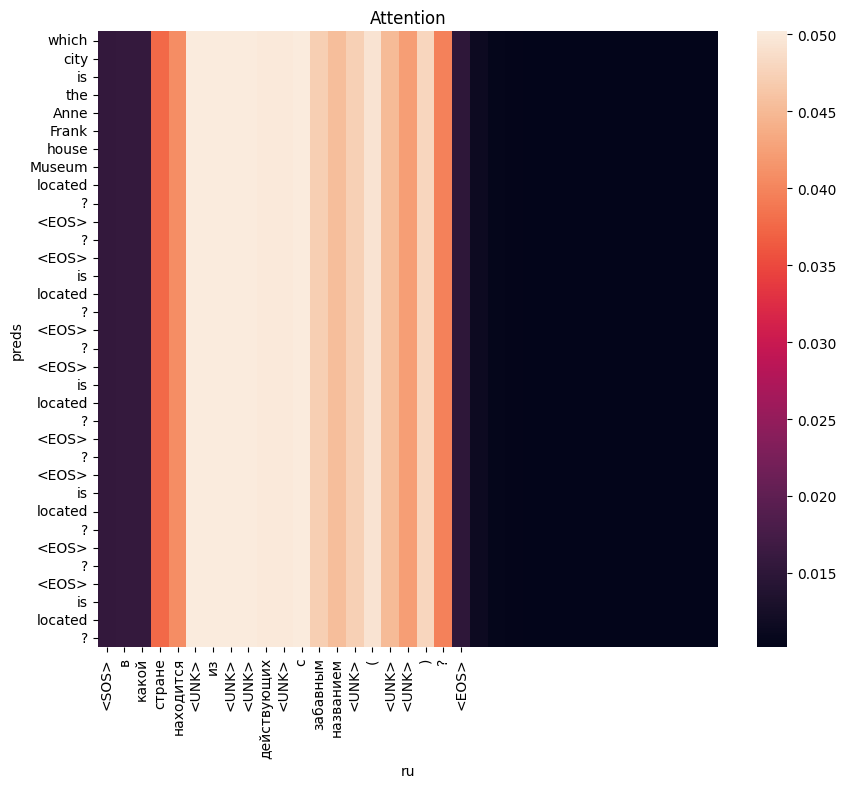

In [ ]:
model.eval()
with torch.no_grad():
    for x_batch, y_batch in test_loader:
        x_batch = x_batch.to(device)
        y_batch = y_batch.to(device)

        encoder_outputs, encoding = model.encoder(x_batch)

        logits, attn_weights = model.decoder(encoding, encoder_outputs, labels=None)

        pred_ids = logits.argmax(dim=-1)[5].tolist()
        attn_matrix = attn_weights[5]

        ru_tokens = [ru_inverse[idx] for idx in x_batch[5].tolist() if idx != 0]
        tgt_tokens = [eng_inverse[idx] for idx in pred_ids if idx != 0]


        plot_attention(attn_matrix, ru_tokens, tgt_tokens)

        break
